In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import glob

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/Shareddrives/Parking_pred/kunik'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train = pd.read_excel(data_path + '/data_0625/train.xlsx')
test = pd.read_excel(data_path + '/data_0625/test.xlsx')

submission = pd.read_excel('/content/drive/Shareddrives/Parking_pred/data/Encoded/sample_submission.xlsx')

In [3]:
train_code = ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
test_code = ['C2335', 'C1327']
submission_code = ['C2335', 'C1327', 'C2675']

for c in train_code:
    train = train[train['단지코드'] != c]

for c in test_code:
    test = test[test['단지코드'] != c]

# for c in submission_code:
#     submission = submission[submission['code'] != c]

train.shape, test.shape, submission.shape

((2896, 15), (1016, 14), (150, 2))

In [4]:
c2085 = train[train['단지코드'] == 'C2085'].index
train.loc[c2085, '단지코드'] = 'C1397'

c1397 = train[train['단지코드'] == 'C1397'].index
train.loc[c1397, '총세대수'] = 1339

In [5]:
c2461 = train[train['단지코드'] == 'C2431'].index
train.loc[c2461, '단지코드'] = 'C1649'

c1649 = train[train['단지코드'] == 'C1649'].index
train.loc[c1649, '총세대수'] = 1047
train.loc[c1649, '등록차량수'] = 1214

In [6]:
c2675 = test[test['단지코드'] == 'C2675']
c2675['등록차량수'] = 1279
c2675['단지코드'] = 'C1036'
c2675

test = test[test['단지코드'] != 'C2675']

train = train.append(c2675)
train = train.reset_index(drop=True)
c1036 = train[train['단지코드'] == 'C1036'].index
train.loc[c1036, '총세대수'] = 1254

test[test['단지코드'] == 'C2675'], train[train['단지코드'] == 'C1036']

(Empty DataFrame
 Columns: [단지코드, 총세대수, 임대건물구분, 지역, 공급유형, 전용면적, 전용면적별세대수, 공가수, 자격유형, 임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수, 단지내주차면수]
 Index: [],        단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
 1490  C1036  1254    아파트  ...                3.0    1016   1279
 1491  C1036  1254    아파트  ...                3.0    1016   1279
 1492  C1036  1254    아파트  ...                3.0    1016   1279
 1493  C1036  1254    아파트  ...                3.0    1016   1279
 1494  C1036  1254    아파트  ...                3.0    1016   1279
 1495  C1036  1254    아파트  ...                3.0    1016   1279
 1496  C1036  1254    아파트  ...                3.0    1016   1279
 2896  C1036  1254    아파트  ...                3.0    1016   1279
 2897  C1036  1254    아파트  ...                3.0    1016   1279
 2898  C1036  1254    아파트  ...                3.0    1016   1279
 2899  C1036  1254    아파트  ...                3.0    1016   1279
 2900  C1036  1254    아파트  ...                3.0    

In [7]:
def get_mod_miss_households(data):
    total = data.iloc[0]['총세대수']
    sum_hh = data['전용면적별세대수'].sum()
    miss = total - sum_hh
    prop = (data['전용면적별세대수'] / sum_hh).tolist()
    miss_prop = [int(p * miss) for p in prop]
    int_miss = miss - sum(miss_prop)
    for i in range(int_miss):
        miss_prop[(i)%len(miss_prop)] += 1

    update = miss_prop+data['전용면적별세대수']
    return update

total_miss = ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804',
                'C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', 
                'C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 
                'C1584', 'C2298', 'C2225', 'C1218', 'C1970', 'C1732', 'C2433', 'C1894', 'C1156', 'C2142', 
                'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', 
                'C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

for tm in total_miss:
    if train[train['단지코드'] == tm].shape[0] == 0 and test[test['단지코드'] == tm].shape[0] == 0:
        print("Empty: {}".format(tm))

        continue  

    elif train[train['단지코드'] == tm].shape[0] == 0:
        mod = get_mod_miss_households(test[test['단지코드'] == tm])
        idx = test[test['단지코드'] == tm].index
        test.loc[idx, '전용면적별세대수'] = mod
        print(test[test['단지코드'] == tm])
    else:
        mod = get_mod_miss_households(train[train['단지코드'] == tm])
        idx = train[train['단지코드'] == tm].index
        train.loc[idx, '전용면적별세대수'] = mod
        print(train[train['단지코드'] == tm])

# Empty 'C1218'

       단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
2144  C1490   749    아파트  ...                3.0     759    899
2145  C1490   749    아파트  ...                3.0     759    899
2146  C1490   749    아파트  ...                3.0     759    899
2147  C1490   749    아파트  ...                3.0     759    899

[4 rows x 15 columns]
      단지코드  총세대수  ... 도보 10분거리 내 버스정류장 수 단지내주차면수
729  C2497   488  ...                  6     624
730  C2497   488  ...                  6     624
731  C2497   488  ...                  6     624
732  C2497   488  ...                  6     624

[4 rows x 14 columns]
       단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
2164  C2620  1029    아파트  ...                6.0    1061   1709
2165  C2620  1029    아파트  ...                6.0    1061   1709
2166  C2620  1029    아파트  ...                6.0    1061   1709
2167  C2620  1029    아파트  ...                6.0    1061   1709
2168  C2620  1029    아파트  ...                6.0    1061   1709

[5 r

In [8]:
# 인덱스 재설정해서 빈 인덱스 채움
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,아파트,경기도,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,아파트,경기도,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,아파트,경기도,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


In [9]:
check_Nan = train.isnull()
print(check_Nan.sum())
check_Nan

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           581
임대료                             590
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2900,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2902,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [10]:
check_Nan = test.isnull()
print(check_Nan.sum())
check_Nan

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           186
임대료                             186
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,False,False,False,False,False,False,False,False,False,True,True,False,False,False
1004,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1005,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1006,False,False,False,False,False,False,False,False,False,False,False,False,False,False


전용면적별 세대수에 비례해서 단지내주차면수, 등록차량수 변환

In [11]:
for i in range(len(test)):
  print(test['전용면적별세대수'][i] / test['총세대수'][i])

0.15384615384615385
0.03978779840848806
0.14854111405835543
0.15915119363395225
0.07957559681697612
0.06763925729442971
0.2625994694960212
0.08885941644562334
0.2717872968980798
0.022156573116691284
0.01624815361890694
0.04431314623338257
0.08567208271787297
0.1329394387001477
0.01772525849335303
0.3072378138847858
0.1019202363367799
0.13247172859450726
0.18578352180936994
0.05654281098546042
0.024232633279483037
0.03877221324717286
0.13893376413570274
0.13893376413570274
0.21324717285945072
0.07108239095315025
0.4266441821247892
0.13827993254637436
0.2934232715008432
0.14165261382799327
0.2174248265227448
0.110254433307633
0.06013878180416345
0.07093292212798766
0.18966846569005397
0.11719352351580571
0.1202775636083269
0.1141094834232845
0.10840932117527863
0.017223910840932118
0.23860182370820668
0.0364741641337386
0.034447821681864235
0.1702127659574468
0.0547112462006079
0.0364741641337386
0.24873353596757852
0.030395136778115502
0.0243161094224924
0.1816160118606375
0.47813194959

In [12]:
# # 왜 정수로 나오는지 의문

# def devide_parking_lots(data, devided_info):
#     for col in devided_info:
#         for i in range(len(data)):
#             prop = data['전용면적별세대수'][i] / data['총세대수'][i]
#             data[col][i]= (data[col][i] * prop)

# devided_info = ['단지내주차면수', '등록차량수']
# devide_parking_lots(train, devided_info)
# devided_info_test = ['단지내주차면수']
# devide_parking_lots(test, devided_info_test)
# train


In [13]:
def devide_parking_lots(data, devided_info):
    for col in devided_info:
        temp=[]
        for i in range(len(data)):
            temp.append(data[col][i] * (data['전용면적별세대수'][i] / data['총세대수'][i]))
        
        index = data.columns.get_loc(col)
        data.insert(index,col+'_tm',temp,True)
        data.drop([col], axis=1, inplace = True)
        
        data.rename(columns={col+'_tm': col}, inplace = True)

devided_info = ['단지내주차면수', '등록차량수']
devide_parking_lots(train, devided_info)
devided_info_test = ['단지내주차면수']
devide_parking_lots(test, devided_info_test)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,316.007339,103.816514
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,68.697248,22.568807
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,22.899083,7.522936
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,43.508257,14.293578
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,21.754128,7.146789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,40.510367,50.996810
2900,C1036,1254,아파트,경기도,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,71.298246,89.754386
2901,C1036,1254,아파트,경기도,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,24.306220,30.598086
2902,C1036,1254,아파트,경기도,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,60.765550,76.495215


공가수 공가율로 전환

In [14]:
for i in range(len(train)):  
  print(train['공가수'][i] / train['총세대수'][i])

0.031192660550458717
0.031192660550458717
0.031192660550458717
0.031192660550458717
0.031192660550458717
0.031192660550458717
0.031192660550458717
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.01069078947368421
0.007947019867549669
0.007947019867549669
0.007947019867549669
0.007947019867549669
0.007947019867549669
0.007947019867549669
0.020114942528735632
0.020114942528735632
0.020114942528735632
0.020114942528735632
0.015901060070671377
0.015901060070671377
0.015901060070671377
0.015901060070671377
0.015901060070671377
0.015901060070671377
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.005807200929152149
0.020833333333333332
0.0

공가수를 공가율로 전환

In [15]:
# def vacant_ratio(data):
#     temp = []
#     for i in range(len(data)):  
#         temp.append(data['공가수'][i] / data['총세대수'][i])
#     data.insert(7,"공가율",temp,True)
#     data.drop(['공가수'],axis=1,inplace=True)
#     return data

# train = vacant_ratio(train)
# test = vacant_ratio(test)

지하철 노선 수, 결측값 처리 후 0 or 1 로 바꿔주기

In [16]:
# 지하철이 있는 5개 지역 중 nan 값을 갖는 데이터는 1을 넣어주고 5개 지역이 아닌 데이터는 0넣어서 결측값 처리
# 지하철이 한 개 이상 있는 데이터는 전부 1로 처리

area = ['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']

def subway(data, area):
    tm = data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].unique()
    na = pd.isna(tm)
    if True in na:
        for a in area:
            data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(pd.Series(np.where(data['지역'] == a, 1, 0)), inplace=True)

        tm = [t for t in tm if pd.isna(t) == False]        
        tm.remove(0)
        data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].replace(tm, 1, inplace=True)
    else:
        tm.remove(0)
        data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].replace(tm, 1, inplace=True)

subway(train, area)
subway(test, area)


In [17]:
# train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].unique()

버스 결측값 처리

In [18]:
# 지역 평균 값으로 결측값 채우기

def bus(data):
    area = data['지역'].unique()

    for a in area:
        n = np.rint(data[data['지역']==a]['도보 10분거리 내 버스정류장 수'].mean())
        data['도보 10분거리 내 버스정류장 수'].fillna(pd.Series(np.where(data['지역'] == a, n, data['지역'])), inplace=True)


bus(train)
bus(test)

check_Nan = train.isnull()
print(check_Nan.sum())

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           581
임대료                             590
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64


임대료 임대보증금 결측값 채우기


In [19]:
check_Nan = train.isnull()
print(check_Nan.sum())

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           581
임대료                             590
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64


In [20]:
# 임대료 임대보증금 corr가장 큰 전용면적 이용해서 결측값 채움
# proportion (임대료/전용면적)의 평균 이용

def rent(data, feature):
    for col in feature:
        temp=[]
        for i in range(len(data)):
            temp.append(data[col][i]/data['전용면적'][i])

        proportion = np.nanmean(temp)
        print(col+" proportion = "+ str(proportion))

        rent_mean =  data['전용면적']*proportion

        data[col].fillna(pd.Series(np.where(pd.isnull(data[col]) == True, rent_mean, data[col])), inplace=True)



feature = ['임대보증금', '임대료']
rent(train, feature)
rent(test, feature)

임대보증금 proportion = 594573.5397307771
임대료 proportion = 4193.119020710472
임대보증금 proportion = 586275.7444635663
임대료 proportion = 4050.215435929288


In [21]:
check_Nan = train.isnull()
print(check_Nan.sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64


In [22]:
check_Nan = test.isnull()
print(check_Nan.sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            2
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
dtype: int64


mapping

In [23]:
# 지역

local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
    
print(local_map)

train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

{'경상남도': 0, '대전광역시': 1, '경기도': 2, '전라북도': 3, '강원도': 4, '광주광역시': 5, '충청남도': 6, '부산광역시': 7, '제주특별자치도': 8, '울산광역시': 9, '충청북도': 10, '전라남도': 11, '경상북도': 12, '대구광역시': 13, '서울특별시': 14, '세종특별자치시': 15}


In [24]:
# 임대건물구분

local_map = {}
for i, loc in enumerate(train['임대건물구분'].unique()):
    local_map[loc] = i
    
print(local_map)

train['임대건물구분'] = train['임대건물구분'].map(local_map)
test['임대건물구분'] = test['임대건물구분'].map(local_map)

train['임대건물구분']

{'아파트': 0, '상가': 1}


0       0
1       0
2       0
3       0
4       0
       ..
2899    0
2900    0
2901    0
2902    0
2903    0
Name: 임대건물구분, Length: 2904, dtype: int64

In [25]:
local_map = {}
for i, loc in enumerate(train['공급유형'].unique()):
    local_map[loc] = i
    
print(local_map)

train['공급유형'] = train['공급유형'].map(local_map)
test['공급유형'] = test['공급유형'].map(local_map)

train['공급유형']

{'국민임대': 0, '공공임대(50년)': 1, '영구임대': 2, '임대상가': 3, '공공임대(10년)': 4, '공공임대(분납)': 5, '장기전세': 6, '공공분양': 7, '행복주택': 8, '공공임대(5년)': 9}


0       0
1       0
2       0
3       0
4       0
       ..
2899    0
2900    0
2901    0
2902    0
2903    0
Name: 공급유형, Length: 2904, dtype: int64

In [26]:
local_map = {}
for i, loc in enumerate(train['자격유형'].unique()):
    local_map[loc] = i
    
print(local_map)

train['자격유형'] = train['자격유형'].map(local_map)
test['자격유형'] = test['자격유형'].map(local_map)

train['자격유형']

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14}


0       0
1       0
2       0
3       0
4       0
       ..
2899    0
2900    0
2901    0
2902    0
2903    0
Name: 자격유형, Length: 2904, dtype: int64

In [27]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

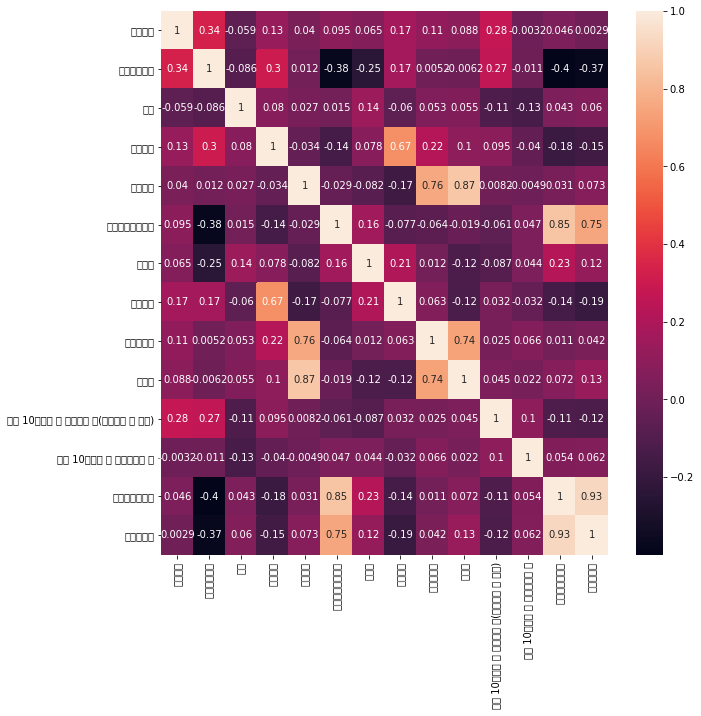

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), annot=True)

결측값 처리

In [29]:
# 임시

train = train.fillna(-1)
test = test.fillna(-1)

In [30]:
x_train = train.iloc[:, 1:-1]
y_train = train.iloc[:,-1]
x_test = test.iloc[:,1:]

scaling


In [31]:
# Scaling

import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
    )

class ScalingFactor:
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features

def scaling(data, scaler, features):

    temp = data.copy()

    target_cols = features
    temp = temp[target_cols]
    
    scaler.fit(temp)

    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data

def preprocess_data(data, scale_factors):
    
    temp = data.copy()

    for factor in scale_factors:
        temp = scaling(temp, factor.scaler, factor.features)

    return temp

In [32]:
scale_factors = []

# scale_factors.append(ScalingFactor(PowerTransformer(method='yeo-johnson'),  
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))
# scale_factors.append(ScalingFactor(PowerTransformer(method='box-cox'), 
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))


# scale_factors.append(ScalingFactor(StandardScaler(),  
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))

# scale_factors.append(ScalingFactor(PowerTransformer(),  
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))


# scale_factors.append(ScalingFactor(RobustScaler(),  
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))

# scale_factors.append(ScalingFactor(MinMaxScaler(),  
#       ['총세대수', '임대건물구분', '지역', 
#        '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
#        '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
#        '단지내주차면수']
#        ))

features_selected = ['총세대수', '임대건물구분', '지역', 
       '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수']

scale_factors.append(ScalingFactor(StandardScaler(), features_selected))
scale_factors.append(ScalingFactor(MinMaxScaler(), features_selected))


x_train = preprocess_data(x_train, scale_factors)
x_test = preprocess_data(x_test, scale_factors)


print(x_train.shape)
print(x_test.shape)
print(x_train)

(2904, 13)
(1008, 13)
          총세대수  임대건물구분  ...  도보 10분거리 내 버스정류장 수   단지내주차면수
0     0.204170     0.0  ...                0.15  0.408680
1     0.204170     0.0  ...                0.15  0.088733
2     0.204170     0.0  ...                0.15  0.029484
3     0.204170     0.0  ...                0.15  0.056146
4     0.204170     0.0  ...                0.15  0.028002
...        ...     ...  ...                 ...       ...
2899  0.483084     0.0  ...                0.15  0.052267
2900  0.483084     0.0  ...                0.15  0.092098
2901  0.483084     0.0  ...                0.15  0.031304
2902  0.483084     0.0  ...                0.15  0.078472
2903  0.483084     0.0  ...                0.15  0.015581

[2904 rows x 13 columns]


train_test_split 

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, 
                                                      random_state=42,shuffle=True)

model selection

In [34]:
# # ALL_models

# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import ARDRegression
# from sklearn.linear_model import BayesianRidge
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from lightgbm import LGBMRegressor
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import RANSACRegressor
# # from catboost import Pool, CatBoostRegressor
# from sklearn.preprocessing import PolynomialFeatures
# # xgboost, lightgbm, catboost install at Anaconda promtp

# linear = LinearRegression()
# ridge = Ridge()
# lasso = Lasso()
# elasticnet = ElasticNet()
# ard = ARDRegression()
# bayesianridge = BayesianRidge()
# randomforest = RandomForestRegressor()
# xgb = XGBRegressor()
# gbm = GradientBoostingRegressor()
# lgbm = LGBMRegressor()
# ransac = RANSACRegressor()
# # catboost = CatBoostRegressor()
# # polynomial = PolynomialFeatures(degree=4)


# models_list = [linear, ridge, lasso, elasticnet, ard, bayesianridge,
#                 randomforest, xgb, gbm, lgbm, ransac]


In [35]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import cross_val_score

# score_dic = dict()

# def regressor(X_train, Y_train, X_test, Y_test):
    
#     score_dic = dict()

#     for model in models_list:
        
#         model.fit(X_train,Y_train)
#         pred = model.predict(X_test)
#         score = mean_absolute_error(Y_test, pred)
        
#         val_scores = cross_val_score(model, X_train, Y_train, cv=4, scoring='neg_mean_absolute_error',
#                                  verbose=0, n_jobs=-1)
#         val_scores_mean = val_scores.mean()
#         score_dic[model] = score, val_scores_mean
    
#     score_dic = sorted(score_dic.items(), key=lambda t : t[1])
#     return score_dic

# regressor_scores = regressor(X_train,Y_train,X_test,Y_test)
# print(regressor_scores)


In [36]:
# models_scores = []
# models_validation_scores = []
# for i in range(len(models_list)):

#     models_scores.append(regressor_scores[i][1][0])
#     models_validation_scores.append(regressor_scores[i][1][1])
# print(models_scores)
# print(models_validation_scores)

In [37]:
# import matplotlib.pyplot as plt
# import re

# models_name = []
# for model in models_list:

#     models_name.append(str(model).split('(')[0])

# print(models_name)


# plt.barh(models_name, models_scores)
# plt.barh(models_name, models_validation_scores)
# # 위에서 sorted 된거 고려해서 수정필요

model

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [39]:
# !pip install catboost

In [40]:
# # CATBOOST

# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, 
#                                                       random_state=42, shuffle=True)

# from catboost import CatBoostRegressor
# cat = CatBoostRegressor(
#         loss_function='MAE',
#         n_estimators=300, 
#         learning_rate=0.05, 
#         random_state=42     
#     )
# cat.fit(x_train, y_train, eval_set=(x_valid, y_valid), use_best_model=True)
# pred = cat.predict(x_test)
# pred = np.rint(pred)

# from sklearn.metrics import mean_absolute_error

# score = mean_absolute_error(y_valid, cat.predict(x_valid))
# score

MAE score

In [41]:
# Score

from sklearn.metrics import mean_absolute_error

def Score(model, Y_test, pred):
    
    return mean_absolute_error(Y_test, pred)    

model.fit(X_train, Y_train)
pred = model.predict(X_test)
print("Score : " + str(Score(model, Y_test, pred)))

Score : 14.98766757406398


pred

In [42]:
#Cross Validation scores

from sklearn.model_selection import cross_val_score

def cross_validation_score(model, x_train, y_train):
    
    scores = cross_val_score(model, x_train, y_train, cv=4, scoring='neg_mean_absolute_error',
                             verbose=1, n_jobs=-1 )
    
    scores_mean = scores.mean()
    
    return scores_mean

model.fit(x_train, y_train)
print("\nvalidation set scores = "+ str(cross_validation_score(model, x_train, y_train)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



validation set scores = -19.56105728787209


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.4s finished


In [43]:
pred = model.predict(x_test)
pred = np.rint(pred)

pred을 단지별 데이터로 합해서 submit

In [44]:
code = test['단지코드'].unique()
num_of_code = []

for c in code:
    num_of_code.append(len(test[test['단지코드'] == c]))

pred_submission = []
pred_list = pred.tolist()

for n in num_of_code:
    num = 0
    for j in range(n):
        num += pred_list.pop(0)

    pred_submission.append(num)

pred_submission

[779.0,
 1341.0,
 556.0,
 629.0,
 1260.0,
 1826.0,
 998.0,
 522.0,
 317.0,
 321.0,
 564.0,
 282.0,
 494.0,
 334.0,
 337.0,
 263.0,
 560.0,
 338.0,
 176.0,
 756.0,
 271.0,
 516.0,
 498.0,
 567.0,
 478.0,
 138.0,
 145.0,
 581.0,
 602.0,
 584.0,
 1088.0,
 175.0,
 559.0,
 279.0,
 126.0,
 339.0,
 448.0,
 577.0,
 745.0,
 341.0,
 505.0,
 492.0,
 421.0,
 644.0,
 883.0,
 1220.0,
 558.0,
 662.0,
 426.0,
 370.0,
 855.0,
 318.0,
 1075.0,
 698.0,
 657.0,
 264.0,
 609.0,
 357.0,
 505.0,
 216.0,
 418.0,
 522.0,
 1031.0,
 475.0,
 193.0,
 316.0,
 542.0,
 971.0,
 583.0,
 528.0,
 712.0,
 315.0,
 635.0,
 1017.0,
 1176.0,
 514.0,
 780.0,
 800.0,
 985.0,
 863.0,
 1050.0,
 358.0,
 248.0,
 340.0,
 266.0,
 227.0,
 386.0,
 348.0,
 981.0,
 938.0,
 652.0,
 334.0,
 651.0,
 1252.0,
 997.0,
 700.0,
 1138.0,
 834.0,
 715.0,
 668.0,
 420.0,
 843.0,
 734.0,
 955.0,
 694.0,
 1213.0,
 672.0,
 905.0,
 280.0,
 558.0,
 943.0,
 955.0,
 1109.0,
 747.0,
 163.0,
 162.0,
 514.0,
 888.0,
 1550.0,
 626.0,
 846.0,
 799.0,
 418.0,
 

In [45]:
pred_submission.insert(77,99999)
pred_submission.insert(130,99999)
pred_submission.insert(140,99999)

In [46]:
submission['num'] = pred_submission

submission.to_csv(data_path + '/submission/sample_submission.csv', index=False)